# DEMO: using parallelAPES to run pyAPES simulations in parallel

In this demo we're going to perform a simple sensitivity analysis for pyAPES. The goal is to take a set of input parameters that describe the forest around SMEAR II station located in Hyytiälä, Finland and vary the forest structure (by varying the maximum leaf area index (LAI) of each tree species). We'll be running altogether 10 simulations and we're going to run them in parallel using the parallelAPES.py module. 

## Imports

In [1]:
# setting pyAPES into path
import sys
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
hyytiala_forcing = os.getenv('HYYTIALA_FORCING')
lad_data = os.getenv('HYYTIALA_LAD_PROFILES')

sys.path.append(pyAPES_main_folder)

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
from multiprocessing import Process, Queue
from copy import deepcopy

In [3]:
from pyAPES.parameters.mlm_outputs import parallel_logging_configuration, output_variables
from pyAPES.parameters.parameter_tools import get_parameter_list
from pyAPES.utils.utilities import lad_constant
from pyAPES.parallelAPES import driver

## Define model input parameters

We won't go through what each parameter does here. For description of input parameters see [Demo_multi_layer_model.ipynb](Demo_multi_layer_model.ipynb). See also modules in the parameters folder.

### General parameters

In [13]:
gpara = {'dt': 1800.0,  # timestep in forcing data file [s]
         'start_time': "2018-06-01",  # start time of simulation [yyyy-mm-dd]
         'end_time': "2018-07-01",  # end time of simulation [yyyy-mm-dd]
         'forc_filename': hyytiala_forcing,  # forcing data file
         'results_directory': 'results/'
         }

### Canopy parameters

#### Control flags

In [14]:
# --- Model control flags
ctr = {'Eflow': True,  # use ensemble flow statistics; i.e fixed ratio of Utop/ustar.
       'WMA': False,  # assume air-space scalar profiles well-mixed
       'Ebal': True,  # computes leaf temperature by solving energy balance
       'WaterStress': 'Rew',  # How soil water limitations are accounted for: 'Rew' |'PsiL' | None
       'seasonal_LAI': True,  # account for seasonal LAI dynamics
       'pheno_cycle': True  # account for phenological cycle
       }

#### SMEAR II location

In [15]:
# site location
loc = {'lat': 61.51,  # latitude, decimal deg
       'lon': 24.0  # longitude, decimal deg
       }

#### Define canopy grid

In [17]:
# grid
grid = {'zmax': 25.0,  # heigth of grid from ground surface. Corresponds to height of forcing data [m]
        'Nlayers': 101  # number of layers [-]
        }

z = np.linspace(0, grid['zmax'], grid['Nlayers'])  # grid [m] above ground

#### Micrometeorology

In [18]:
# --- Turbulent flow & scalar transport in air-space: pyAPES.microclimate.micromet.Micromet
micromet = {'zos': 0.01,  # forest floor roughness length [m]
            'dPdx': 0.0,  # horizontal pressure gradient [units]
            'Cd': 0.15,  # drag coefficient [-]
            'Utop': 5.0,  # ensemble U/ustar [-]
            'Ubot': 0.01,  # flow at lower boundary [m s-1 or -]
            'Sc': {'T': 2.0, 'H2O': 2.0, 'CO2': 2.0}  # turbulent Schmidt numbers in canopy flow
            }

#### Radiation

In [19]:
# --- Short- and long-wave radiation: pyAPES.microclimate.radiation.Radiation
radiation = {'clump': 0.7,  # clumping index [-]
             'leaf_angle': 1.0,  # leaf-angle distribution [-]
             'Par_alb': 0.1,  # shoot Par-albedo [-]
             'Nir_alb': 0.39,  # shoot NIR-albedo [-]
             'leaf_emi': 0.98  # leaf emissivity [-]
             }

#### Interception

In [20]:
# --- Rainfall and snow interception: pyAPES.microclimate.interception.Interception
interception = {'wmax': 0.2,  # maximum interception storage capacity for rain [kg m-2 (leaf), i.e. mm H2O m-2 (leaf)]
                'wmaxsnow': 0.8,  # maximum interception storage capacity for snow [kg m-2 (leaf), i.e. mm H2O m-2 (leaf)]
                'w_ini': 0.0,  # initial canopy storage, fraction of maximum rain storage [-]
                'Tmin': 0.0,  # temperature below which all is snow [degC]
                'Tmax': 2.0,  # temperature above which all is water [degC]
                'leaf_orientation': 0.5, # leaf orientation factor for randomdly oriented leaves
                }

#### Planttypes

##### Load LAD profiles

In [62]:
lad_normed = np.genfromtxt(lad_data, delimiter=';')  # same z as in canopy
lad = lad_normed[:,1:]  # pine, spruce, decid

Text(0, 0.5, 'Height (m)')

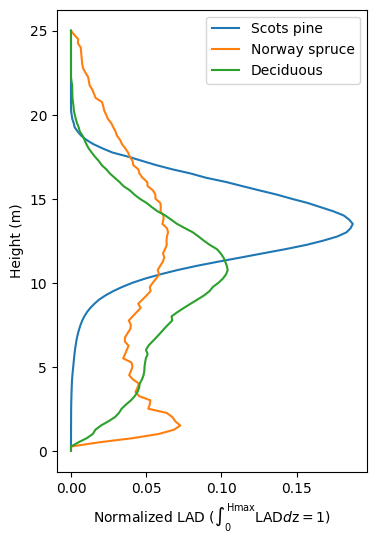

In [45]:
fig, ax = plt.subplots(figsize=(4,6))
lines = ax.plot(lad, z, )
ax.legend(lines, ['Scots pine','Norway spruce','Deciduous'])
ax.set_xlabel(r'Normalized LAD ($\int_0^\mathrm{Hmax} \mathrm{LAD} d\mathrm{z} = 1$)')
ax.set_ylabel('Height (m)')

##### Scots pine

In [46]:
pt1 = { 'name': 'pine',
        'LAImax': 2.1, # maximum annual LAI m2m-2
        'lad': lad[:,0],  # leaf-area density m2m-3
        # seasonal cycle of photosynthetic activity: pyAPES.planttype.phenology.Photo_cycle
        'phenop': {
            'Xo': 0.0, # initial delayed temperature [degC]
            'fmin': 0.1, # minimum relative photosynthetic capacity
            'Tbase': -4.7,  # base temperature [degC]
            'tau': 8.33,  # time constant [d]
            'smax': 15.0  # threshold for full acclimation [degC]
            },
        # seasonal cycle of LAI: #  pyAPES.planttype.phenology.LAI_cycle
        'laip': {
            'lai_min': 0.8, # minimum LAI, fraction of annual maximum [-]
            'lai_ini': None, # initial LAI, if None lai_ini = Lai_min * LAImax
            'DDsum0': 0.0, # initial degree-day sum [degC]
            'Tbase': 5.0, # base temperature for degree-day sy
            'ddo': 45.0, # degree-days at bud burst [days]
            'ddmat': 250.0, #degreedays at full maturation [days]
            'sdl': 12.0, # day length [h] for starting autumn senecence
            'sdur': 30.0 # duration [d] of senescence
            },
        # A-gs model: pyAPES.leaf.photo
        'photop': {
            'Vcmax': 80, # 50.0, # maximum carboxylation rate [umol m-2 (leaf) s-1] at 25 degC
            'Jmax': 160, # 98.0,  # maximum electron transport rate[umol m-2 (leaf) s-1] at 25 degC1.97*Vcmax (Kattge and Knorr, 2007)
            'Rd': 0.9, # 1.2, # dark respiration rate [umol m-2 (leaf) s-1] at 25 degC
            'tresp': { # temperature response (Kattge and Knorr, 2007)
                'Vcmax': [53., 200.0, 640.], # [activation energy [kJ mol-1], deactivation energy [kJ mol-1]
                                 #             entropy factor [kJ mol-1]]
                'Jmax': [38., 200.0, 656.],
                'Rd': [36.0], ##[33.0]
                },
            'alpha': 0.1,   # quantum efficiency parameter [-]
            'theta': 0.7,   # curvature parameter [-]
            'beta': 0.95,   # co-limitation parameter [-]
            'g1': 2.0, # 2.8,      # USO-model stomatal slope kPa^(0.5)
            'g0': 1.0e-3,   # residual conductance for CO2 [mol m-2 s-1]
            'kn': 0.5,      # nitrogen attenuation coefficient; affects Vcmax, Jmax, Rd profile in PlantType [-]
            'drp': [0.39, 0.83, 0.31, 3.0] # Rew-based drought response parameters.
            },
        'leafp': {
            'lt': 0.02,     # leaf length scale [m]
            },

        # root zone: pyAPES.planttype.rootzone.RootUptake
        'rootp': {
            'root_depth': 0.5, # rooting depth [m]
            'beta': 0.943, # root distribution shape parameter [-]
            'root_to_leaf_ratio': 2.0, # fine-root to leaf-area ratio [-]
            'root_radius': 2.0e-3, # [m]
            'root_conductance': 5.0e8, # [s]
            }
        }

##### Norway spruce

In [47]:
pt2 = { 'name': 'spruce',
        'LAImax': 1.2, # maximum annual LAI m2m-2
        'lad': lad[:,1],  # leaf-area density m2m-3
        # seasonal cycle of photosynthetic activity: pyAPES.planttype.phenology.Photo_cycle
        'phenop': {
            'Xo': 0.0, # initial delayed temperature [degC]
            'fmin': 0.1, # minimum relative photosynthetic capacity
            'Tbase': -4.7,  # base temperature [degC]
            'tau': 8.33,  # time constant [d]
            'smax': 18.0  # threshold for full acclimation [degC]
            },
        # seasonal cycle of LAI: #  pyAPES.planttype.phenology.LAI_cycle
        'laip': {
            'lai_min': 0.8, # minimum LAI, fraction of annual maximum [-]
            'lai_ini': None, # initial LAI, if None lai_ini = Lai_min * LAImax
            'DDsum0': 0.0, # initial degree-day sum [degC]
            'Tbase': 5.0, # base temperature for degree-day sy
            'ddo': 45.0, # degree-days at bud burst [days]
            'ddmat': 250.0, #degreedays at full maturation [days]
            'sdl': 12.0, # day length [h] for starting autumn senecence
            'sdur': 30.0 # duration [d] of senescence
            },
        # A-gs model: pyAPES.leaf.photo
        'photop': {
            'Vcmax': 50.0, # maximum carboxylation rate [umol m-2 (leaf) s-1] at 25 degC
            'Jmax': 98.0,  # maximum electron transport rate[umol m-2 (leaf) s-1] at 25 degC1.97*Vcmax (Kattge and Knorr, 2007)
            'Rd': 1.2, # dark respiration rate [umol m-2 (leaf) s-1] at 25 degC
            'tresp': { # temperature response (Kattge and Knorr, 2007)
                'Vcmax': [53., 200.0, 640.], # [activation energy [kJ mol-1], deactivation energy [kJ mol-1]
                                 #             entropy factor [kJ mol-1]]
                'Jmax': [38., 200.0, 656.],
                'Rd': [33.0]
                },
            'alpha': 0.2,   # quantum efficiency parameter [-]
            'theta': 0.7,   # curvature parameter [-]
            'beta': 0.95,   # co-limitation parameter [-]
            'g1': 2.8,      # USO-model stomatal slope kPa^(0.5)
            'g0': 1.0e-3,   # residual conductance for CO2 [mol m-2 s-1]
            'kn': 0.5,      # nitrogen attenuation coefficient; affects Vcmax, Jmax, Rd profile in PlantType [-]
            'drp': [0.39, 0.83, 0.31, 3.0] # Rew-based drought response parameters.
            },
        'leafp': {
            'lt': 0.02,     # leaf length scale [m]
            },

        # root zone: pyAPES.planttype.rootzone.RootUptake
        'rootp': {
            'root_depth': 0.5, # rooting depth [m]
            'beta': 0.943, # root distribution shape parameter [-]
            'root_to_leaf_ratio': 2.0, # fine-root to leaf-area ratio [-]
            'root_radius': 2.0e-3, # [m]
            'root_conductance': 5.0e8, # [s]
            }
        }

##### Deciduous trees

In [48]:
pt3 = { 'name': 'decid',
        'LAImax': 1.2, # maximum annual LAI m2m-2
        'lad': lad[:,2],  # leaf-area density m2m-3
        # seasonal cycle of photosynthetic activity: pyAPES.planttype.phenology.Photo_cycle
        'phenop': {
            'Xo': 0.0, # initial delayed temperature [degC]
            'fmin': 0.01, # minimum relative photosynthetic capacity
            'Tbase': -4.7,  # base temperature [degC]
            'tau': 8.33,  # time constant [d]
            'smax': 18.0  # threshold for full acclimation [degC]
            },
        # seasonal cycle of LAI: #  pyAPES.planttype.phenology.LAI_cycle
        'laip': {
            'lai_min': 0.1, # minimum LAI, fraction of annual maximum [-]
            'lai_ini': None, # initial LAI, if None lai_ini = Lai_min * LAImax
            'DDsum0': 0.0, # initial degree-day sum [degC]
            'Tbase': 5.0, # base temperature for degree-day sy
            'ddo': 45.0, # degree-days at bud burst [days]
            'ddmat': 250.0, #degreedays at full maturation [days]
            'sdl': 12.0, # day length [h] for starting autumn senecence
            'sdur': 30.0 # duration [d] of senescence
            },
        # A-gs model: pyAPES.leaf.photo
        'photop': {
            'Vcmax': 40.0, # maximum carboxylation rate [umol m-2 (leaf) s-1] at 25 degC
            'Jmax': 79.0,  # maximum electron transport rate[umol m-2 (leaf) s-1] at 25 degC1.97*Vcmax (Kattge and Knorr, 2007)
            'Rd': 0.9, # dark respiration rate [umol m-2 (leaf) s-1] at 25 degC
            'tresp': { # temperature response (Kattge and Knorr, 2007)
                'Vcmax': [53., 200.0, 640.], # [activation energy [kJ mol-1], deactivation energy [kJ mol-1]
                                 #             entropy factor [kJ mol-1]]
                'Jmax': [38., 200.0, 656.],
                'Rd': [33.0]
                },
            'alpha': 0.2,   # quantum efficiency parameter [-]
            'theta': 0.7,   # curvature parameter [-]
            'beta': 0.95,   # co-limitation parameter [-]
            'g1': 5.2,      # USO-model stomatal slope kPa^(0.5)
            'g0': 5.0e-3,   # residual conductance for CO2 [mol m-2 s-1]
            'kn': 0.5,      # nitrogen attenuation coefficient; affects Vcmax, Jmax, Rd profile in PlantType [-]
            'drp': [0.39, 0.83, 0.31, 3.0] # Rew-based drought response parameters.
            },
        'leafp': {
            'lt': 0.05,     # leaf length scale [m]
            },

        # root zone: pyAPES.planttype.rootzone.RootUptake
        'rootp': {
            'root_depth': 0.5, # rooting depth [m]
            'beta': 0.943, # root distribution shape parameter [-]
            'root_to_leaf_ratio': 2.0, # fine-root to leaf-area ratio [-]
            'root_radius': 2.0e-3, # [m]
            'root_conductance': 5.0e8, # [s]
            }
        }

##### Shrubs

In [50]:
pt4 = { 'name': 'shrubs',
        'LAImax': 0.7, # maximum annual LAI m2m-2
        'lad': lad_constant(z, LAI=1.0, h=0.5, hb=0.0),  # leaf-area density [m2 m-3]
        # seasonal cycle of photosynthetic activity: pyAPES.planttype.phenology.Photo_cycle
        'phenop': {
            'Xo': 0.0, # initial delayed temperature [degC]
            'fmin': 0.1, # minimum relative photosynthetic capacity
            'Tbase': -4.7,  # base temperature [degC]
            'tau': 8.33,  # time constant [d]
            'smax': 17.3-3.1,  #18.0  # threshold for full acclimation [degC]
            },
        # seasonal cycle of LAI: #  pyAPES.planttype.phenology.LAI_cycle
        'laip': {
            'lai_min': 0.6, # minimum LAI, fraction of annual maximum [-]
            'lai_ini': None, # initial LAI, if None lai_ini = Lai_min * LAImax
            'DDsum0': 0.0, # initial degree-day sum [degC]
            'Tbase': 5.0, # base temperature for degree-day sy
            'ddo': 45.0, # degree-days at bud burst [days]
            'ddmat': 250.0, #degreedays at full maturation [days]
            'sdl': 12.0, # day length [h] for starting autumn senecence
            'sdur': 30.0 # duration [d] of senescence
            },
        # A-gs model: pyAPES.leaf.photo
        'photop': {
            'Vcmax': 40.0, # maximum carboxylation rate [umol m-2 (leaf) s-1] at 25 degC
            'Jmax': 79.0,  # maximum electron transport rate[umol m-2 (leaf) s-1] at 25 degC
            'Rd': 0.9, # dark respiration rate [umol m-2 (leaf) s-1] at 25 degC
            'tresp': { # temperature response (Kattge and Knorr, 2007)
                'Vcmax': [53., 200.0, 640.], # [activation energy [kJ mol-1], deactivation energy [kJ mol-1]
                                 #             entropy factor [kJ mol-1]]
                'Jmax': [38., 200.0, 656.],
                'Rd': [33.0]
                },
            'alpha': 0.2,   # quantum efficiency parameter [-]
            'theta': 0.7,   # curvature parameter [-]
            'beta': 0.95,   # co-limitation parameter [-]
            'g1': 5.2,      # USO-model stomatal slope kPa^(0.5)
            'g0': 5.0e-3,   # residual conductance for CO2 [mol m-2 s-1]
            'kn': 0.0,      # nitrogen attenuation coefficient; affects Vcmax, Jmax, Rd profile in PlantType [-]
            'drp': [0.39, 0.83, 0.31, 3.0] # Rew-based drought response parameters.
            },
        'leafp': {
            'lt': 0.05,     # leaf length scale [m]
            },

        # root zone: pyAPES.planttype.rootzone.RootUptake
        'rootp': {
            'root_depth': 0.5, # rooting depth [m]
            'beta': 0.943, # root distribution shape parameter [-]
            'root_to_leaf_ratio': 2.0, # fine-root to leaf-area ratio [-]
            'root_radius': 2.0e-3, # [m]
            'root_conductance': 5.0e8, # [s]
            }
        }

#### Forest floor

##### Snowpack

In [55]:
# --- pyAPES.snow.snowpack.DegreeDaySnow
snowpack = {
        'kmelt': 2.31e-5,  # Melting coefficient [kg m-2 s-1 degC-1]; (= 2.0 mm degC d-1)
        'kfreeze': 5.79e-6,  # Freezing  coefficient [kg m-2 s-1 degC-1] (=0.5 mm degC d-1)
        'retention': 0.2,  # max fraction of liquid water in snow [-]
        'Tmelt': 0.0,  # temperature when melting starts [degC]
        'optical_properties': {
                'emissivity': 0.97,
                'albedo': {'PAR': 0.8, 'NIR': 0.8}
                },
        'initial_conditions': {'temperature': 0.0,
                               'snow_water_equivalent': 0.0}
        }


##### Soil respiration

In [56]:
# --- pyAPES.bottomlayer.carbon.SoilRespiration
soil_respiration = {
        'r10': 2.5, # base rate (bulk heterotrophic + autotrophic) [umol m-2 (ground) s-1]
        'q10': 2.0, # temperature sensitivity [-]
        'moisture_coeff': [3.83, 4.43, 1.25, 0.854]  # moisture response; Skopp moisture function param [a ,b, d, g]}
        }

##### Ground types

In [53]:
# --- pyAPES.bottomlayer.OrganicLayer
Forest_moss = {
    'name': 'forest mosses',  # Based on literature review of Pleurozium schreberi and Hylocomium splendens
    'layer_type': 'bryophyte',
    'coverage': 1.0, # fractional coverage [-]
    'height': 0.057,  # range (min, max): [0.021, 0.10]
    'roughness_height': 0.01, # [m]
    'bulk_density': 14.3, # kg m-3 range: [7.3, 28.74]
    'max_water_content': 9.7, # g H2O g-1 DM,  range: [7.91, 11.8]
    'water_content_ratio': 0.25,  # [-] max_symplast_water_content:max_water_content -ratio
    'min_water_content': 0.1, # g H2O g-1 DM
    'porosity': 0.98, # macroporosity

    # --- pyAPES.bottomlayer.carbon.BryophyteFarquhar
    'photosynthesis': {
        'Vcmax': 15.0, 'Jmax': 28.5, 'Rd': 0.75, # [umol m-2 (ground) s-1] at 25 degC
        'alpha': 0.3, 'theta': 0.8, 'beta': 0.9, # quantum yield [-], curvature [-], co-limitation[-]
        'gref': 0.02, 'wref': 7.0, 'a0': 0.7, 'a1': -0.263, 'CAP_desic': [0.44, 7.0],
        'tresp': { # temperature response 
                'Vcmax': [78., 200., 649.], # [activation energy, deactivation energy, entropy factor [kJ mol-1]]
                'Jmax': [56., 200., 646.],
                'Rd': [33.0]
                },
    },
    'optical_properties': {
        'emissivity': 0.98,
        'albedo': {'PAR': 0.11, 'NIR': 0.29} # albedo when moss is fully hydrated [-]
    },

    'water_retention': {
        'alpha': 0.17, # air-entry potential [cm-1]  
        'n': 1.68,  # [-], pore connectivity
        'saturated_conductivity': 1.17e-8,  # [m s-1], based on fitted value of other mosses than Sphagnum
        'pore_connectivity': -2.30, # based on fitted value of other mosses than Sphagnum
    },

    'initial_conditions': {
        'temperature': 10.0, # degC
        'water_content': 10.0 # g H2O g-1 DM
    }
}

##### Group forest floor components into one dictionary

In [54]:
forestfloor = {
    'bottom_layer_types': {
        'forest_moss': Forest_moss,
    },
    'snowpack': snowpack,
    'soil_respiration': soil_respiration
}

#### Group canopy components into one dictionary

In [58]:
cpara = {'loc': loc,
         'ctr': ctr,
         'grid': grid,
         'radiation': radiation,
         'micromet': micromet,
         'interception': interception,
         'planttypes': {'pine': pt1, 'spruce': pt2, 'decid': pt3, 'shrubs': pt4},
         'forestfloor': forestfloor
         }

### Soil parameters

In [60]:
# grid and soil properties: pF and conductivity values from Launiainen et al. (2015), Hyytiala
# single soil layer
soil_grid = {#thickness of computational layers [m]
            'dz': [0.10],
            # bottom depth of layers with different characteristics [m]
            'zh': [-0.10]
            }

soil_properties = {'pF': {  # vanGenuchten water retention parameters
                        'ThetaS': [0.50],
                        'ThetaR': [0.08],
                        'alpha': [0.06],
                        'n': [1.35]
                        },
                  'saturated_conductivity_vertical': [2.1E-06],  # saturated vertical hydraulic conductivity [m s-1]
                  'saturated_conductivity_horizontal': [2.1E-06],  # saturated horizontal hydraulic conductivity [m s-1]
                  'solid_heat_capacity': None,  # [J m-3 (solid) K-1] - if None, estimated from organic/mineral composition
                  'solid_composition': {
                          'organic': [0.1611],
                          'sand': [0.4743],
                          'silt': [0.3429],
                          'clay': [0.0217]
                          },
                  'freezing_curve': [0.2],  # freezing curve parameter
                  'bedrock': {
                              'solid_heat_capacity': 2.16e6,  # [J m-3 (solid) K-1]
                              'thermal_conductivity': 3.0  # thermal conductivity of non-porous bedrock [W m-1 K-1]
                              }
                  }

#### Soil water parameters

In [61]:
water_model = {'solve': False,
               'type': 'Richards',  # solution approach 'Richards' | 'Equilibrium'
               'pond_storage_max': 0.05,  #  maximum pond depth [m]
               'initial_condition': {
                       'ground_water_level': -2.0,  # groundwater depth [m], <=0
                       'pond_storage': 0.0  # pond depth at surface [m]
                       },
               'lower_boundary': {
                       'type': 'head_oneway',
                       'value': -0.0,
                       },
               'drainage_equation': {
                       'type': None,  #

                       }
                }

#### Soil heat parameters

In [62]:
heat_model = {'solve': False,
              'initial_condition': {
                      'temperature': 4.0,  # initial soil temperature [degC], assumed constant with dept - can also be array of correct length.
                      },
              'lower_boundary': {  # lower boundary condition (type, value)
                      'type': 'temperature',
                      'value': 4.0
                      },
              }

#### Group soil components into one dictionary

In [63]:
spara = {'grid': soil_grid,
         'soil_properties': soil_properties,
         'water_model': water_model,
         'heat_model': heat_model}

### Group all parameters into one dictionary

In [65]:
parameters = {
    'general': gpara,
    'canopy': cpara,
    'soil': spara
    }

## Define simulation scenarios

The goal here is to define dictionary that shows which model parameters should change between simulations.

In this example we'll be changing the maximum LAI linearly from 0.5 to 5 m<sup>2</sup>m<sup>-2</sup> in 10 total simulations. We'll keep the original ratios between different plant types (pine, spruce, deciduous and shrubs).

Once we've created the dictionary that shows what the LAI should be in each simulations, we'll use the get_parameter_list function in parameters package to create 10 different sets of parameters where the difference is only in the maximum annual LAI of each plant type.


In [76]:
Nsim = 10 # Number of simulations

# The original LAImax are pine=2.1; spruce=1.2; decid=1.2; shrubs=0.7
# Keep the same ratio 1.75:1 for pine:spruce or decid and 3:1 for pine:shrubs.
# i.e., ca. 40% pine 23% spruce and decid and 13% shrubs

LAI_original = [parameters['canopy']['planttypes'][species]['LAImax'] for species in ['pine','spruce','decid','shrubs']]
LAI_original_total = np.sum(LAI_original)
LAI_ratio = LAI_original/LAI_original_total

# Create an array of increasing total LAI from 0.5 to 5
LAI_total = np.linspace(0.5, 5, Nsim)
LAI_pine = tuple(LAI_total * LAI_ratio[0])
LAI_spruce = tuple(LAI_total * LAI_ratio[1])
LAI_decid = tuple(LAI_total * LAI_ratio[2])
LAI_shrubs = tuple(LAI_total * LAI_ratio[3])

hyytiala_2018_lad_parameters = {
    'count': Nsim, # Number of simulations
    'scenario': 'hyytiala_2018_lad',
    'canopy': {
        'planttypes': {
            'pine': {
                'LAImax': LAI_pine,
            },
            'spruce': {
                'LAImax': LAI_spruce
            },
            'decid': {
                'LAImax': LAI_decid
            },
            'shrubs': {
                'LAImax': LAI_shrubs
            },
        }
    }
}

### Call get_parameter_list

tasks will be a list of 10 elements where each element contains parameters for one simulation

In [78]:
tasks = get_parameter_list(parameters, hyytiala_2018_lad_parameters)
len(tasks)

10

## Start multiprocessing

In [ ]:
# --- Queues ---
manager = mp.Manager()
logging_queue = Queue()
writing_queue = Queue()
task_queue = Queue()

In [ ]:
filename = 'hyytiala_2018_lad_sensitivity'
# ncf parameters
ncf_params = {
    'variables': output_variables['variables'],
    'Nsim': len(tasks),
    'Nsoil_nodes': len(tasks[0]['soil']['grid']['dz']),
    'Ncanopy_nodes': tasks[0]['canopy']['grid']['Nlayers'],
    'Nplant_types': len(tasks[0]['canopy']['planttypes']),
    'Nground_types': 1,
    'time_index': tasks[0]['forcing'].index,
    'filename': f'{filename}{time.strftime('_%Y%m%d%H%M')}.nc',
    'filepath': tasks[0]['general']['results_directory'],
}

In [88]:
for para in tasks:
    task_queue.put(deepcopy(para))

# --- Number of workers ---
Ncpu = 4

N_workers = Ncpu - 1

parallel_logging_configuration['handlers']['parallelAPES_file']['filename'] = f'{filename}{time.strftime('_%Y%m%d%H%M')}.log'

In [89]:
outputfile = driver(
    ncf_params=ncf_params,
    logging_configuration=parallel_logging_configuration,
    N_workers=N_workers)

print(outputfile)

NameError: name 'task_queue' is not defined

In [6]:
from mp_test import worker

In [12]:
queue = Queue()
processes = []

for i in range(5):
    process = Process(target=worker, args=(queue, i))
    processes.append(process)
    process.start()

for process in processes:
    process.join()

while not queue.empty():
    print(queue.get())

Message from worker 0
Message from worker 1
Message from worker 2
Message from worker 3
Message from worker 4
